In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow.keras as k

import csv
import json

In [3]:
# helper functions
output_format = ['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'clubs', 'spades', 'diamonds', 'hearts', 'joker']
def parse_output(output: np.array) -> str:
    """
    Parse the output from a list of numbers into a string like 'joker' or 'ace of hearts' or 'eight of spades'
    :param output: the output from the DL model as a list of 18 numbers between 0 and 1
    :return: string name of the card
    """
    if output.shape != np.array(output_format).shape:
        raise ValueError('output is not of the correct shape')
    if max(output) == output[-1]:
        return 'joker'
    outputs = list(output)
    rank_index = outputs[:13].index(max(output[:13]))
    suit_index = outputs[13:17].index(max(output[13:17])) + 13
    return f"{output_format[rank_index]} of {output_format[suit_index]}"    

In [4]:
# import and assemble data
train_inputs = []
train_outputs = []
validation_inputs = []
validation_outputs = []
test_inputs = []
test_outputs = []



with open('data/cards.csv', 'r') as file:
    csv_reader = csv.reader(file, delimiter=',')

    flag = True
    for row in csv_reader:
        # print(row)
        if flag:
            headers = row
            flag = False
        else:
            # determine input
            img = np.asarray(Image.open('data/'+row[1]))
            
            # determine output
            name = row[2]
            output = [1 if title in name else 0 for title in output_format]
                
            if sum(output) == 2 and row[2] != 'joker': # suit and number activated
                output = np.array(output)
            elif sum(output) == 1 and row[2] == 'joker': # just joker activated
                output = np.array(output)
            else:
                print(f"Something went wrong with {'data/'+row[1]}.")
                exit(1)
                
            # assembling data
            if 'train' == row[4]:
                train_inputs.append(img)
                train_outputs.append(output)
            elif 'test' == row[4]:
                test_inputs.append(img)
                test_outputs.append(output)
            elif 'valid' == row[4]:
                validation_inputs.append(img)
                validation_outputs.append(output)
            else:
                print(f"Something went wrong with {'data/'+row[1]} and category {row[4]}")
                exit(1)
                
train_inputs = np.array(train_inputs) / 255
train_outputs = np.array(train_outputs)
validation_inputs = np.array(validation_inputs) / 255
validation_outputs = np.array(validation_outputs)
test_inputs = np.array(test_inputs) / 255
test_outputs = np.array(test_outputs)



print("Data importing complete")


Data importing complete


[[[0.95686275 0.95686275 0.95686275]
  [0.96862745 0.96862745 0.96862745]
  [0.98431373 0.98431373 0.98431373]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[0.59215686 0.59215686 0.59215686]
  [0.62745098 0.62745098 0.62745098]
  [0.69803922 0.69803922 0.69803922]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[0.52156863 0.52156863 0.52156863]
  [0.5372549  0.5372549  0.5372549 ]
  [0.57254902 0.57254902 0.57254902]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]


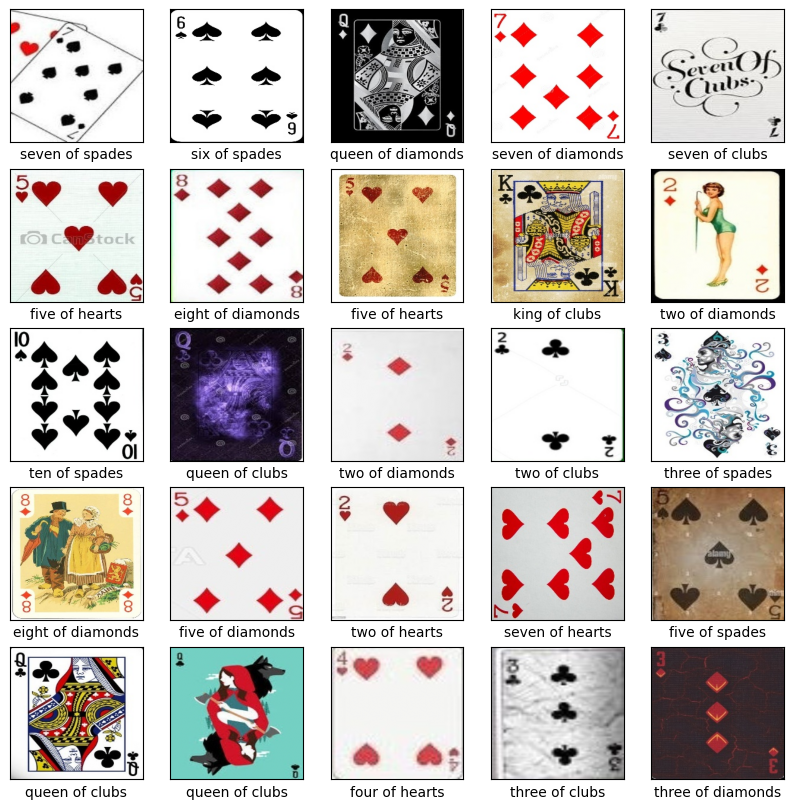

In [5]:
# check random samples
import random

samples = []
index = random.randint(0, len(train_inputs)-1)
while len(samples) < 25:
    if index not in samples:
        samples.append(index)
    index = random.randint(0, len(train_inputs)-1)

plt.figure(figsize=[10,10])
counter = 1

for index in samples:
    print(train_inputs[index])
    plt.subplot(5, 5, counter)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_inputs[index])
    plt.xlabel(parse_output(train_outputs[index]))
    counter += 1
    
plt.show()
        

In [24]:
# Define regularization strength
l1_strength = 0.001

# Define model
model = k.models.Sequential()

model.add(k.Input(shape=(224, 224, 3)))
model.add(k.layers.Conv2D(32, (30, 30), padding='same', strides=(3, 3), activation=tf.keras.activations.relu, kernel_regularizer=k.regularizers.l1(l1_strength)))

model.add(k.layers.MaxPooling2D(pool_size=(7, 7)))
model.add(k.layers.Dropout(0.3))

model.add(k.layers.Flatten())


model.add(k.layers.Dense(256, activation=tf.keras.activations.relu, kernel_regularizer=k.regularizers.l1(l1_strength)))
model.add(k.layers.BatchNormalization())
model.add(k.layers.Dense(len(output_format), activation='softmax'))

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 16)     │        10,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,322 (1.63 MB)

 Trainable params: 425,810 (1.62 MB)

 Non-trainable params: 512 (2.00 KB)

In [26]:
# Learning rate scheduler
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=1000,
    decay_rate=0.99
)

# Create an optimizer with the learning rate schedule
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Compile model
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])


In [27]:
# Train the model
num_epochs = 25
history = model.fit(
    train_inputs, train_outputs,
    epochs=num_epochs,
    batch_size=32,
    validation_data=(validation_inputs, validation_outputs),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 56s 221ms/step - accuracy: 0.0218 - loss: 2.0225 - val_accuracy: 0.0000e+00 - val_loss: 0.2548
Epoch 2/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 51s 212ms/step - accuracy: 0.0108 - loss: 0.2442 - val_accuracy: 0.0038 - val_loss: 0.2517
Epoch 3/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 51s 212ms/step - accuracy: 0.0308 - loss: 0.2461 - val_accuracy: 0.0415 - val_loss: 0.2311
Epoch 4/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 51s 214ms/step - accuracy: 0.0324 - loss: 0.2340 - val_accuracy: 0.0792 - val_loss: 0.2242
Epoch 5/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 52s 216ms/step - accuracy: 0.0690 - loss: 0.2298 - val_accuracy: 0.0755 - val_loss: 0.2244
Epoch 6/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 53s 220ms/step - accuracy: 0.0934 - loss: 0.2239 - val_accuracy: 0.1396 - val_loss: 0.2239
Epoch 7/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 52s 217ms/step - accuracy: 0.1021 - loss: 0.2210 - val_accuracy: 0.1811 - val_loss: 0.2160
Epoch 8/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 53s 221ms/step - accuracy: 0.1024 - los

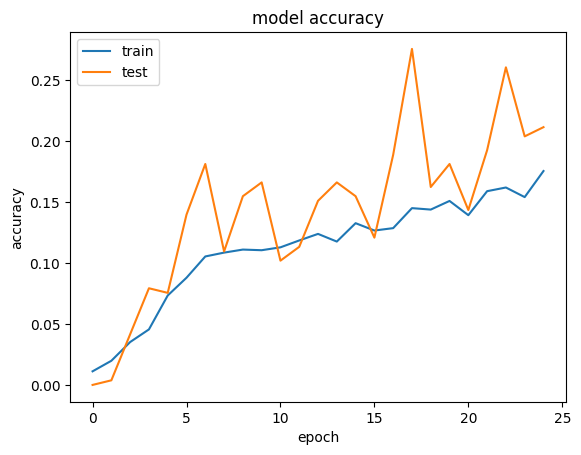

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

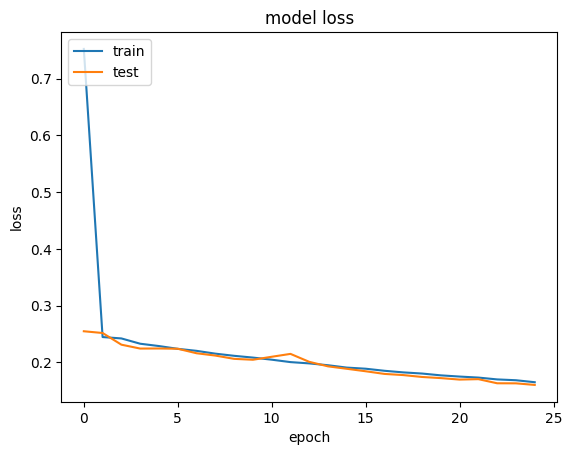

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()